**IBM COURSE 9 CAPSTONE PROJECT**

In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.

**Importing necessary libraries and defining the required functions**

In [64]:
!pip install requests
%pip install folium


# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

Note: you may need to restart the kernel to use updated packages.


In [7]:
import requests
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the rocket column we would like to learn the booster name.

In [8]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the launchpad we would like to know the name of the launch site being used, the logitude, and the latitude.

In [9]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the payload we would like to learn the mass of the payload and the orbit that it is going to.

In [10]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [11]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Lets make the connection to the API

In [12]:
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

**Task 1: Request and parse the SpaceX launch data using the GET request**

In [13]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response.status_code

200

Decoding the response content as a Json usibg .json() and turn it into a Pd using .json_normalize()

In [14]:
data = pd.json_normalize(response.json())
data.head(1)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns rocket, payloads, launchpad, and cores.

In [15]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

From the rocket we would like to learn the booster name

From the payload we would like to learn the mass of the payload and the orbit that it is going to

From the launchpad we would like to know the name of the launch site being used, the longitude, and the latitude.

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [16]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at BoosterVersion variable. Before we apply getBoosterVersion the list is empty:

Apply the relevant methods to get the information we want

In [17]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [18]:
#Checking to see whether the code worked and the list is populated well
BoosterVersion[0:10] 

['Falcon 1',
 'Falcon 1',
 'Falcon 1',
 'Falcon 1',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9',
 'Falcon 9']

In [19]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [20]:
data = pd.DataFrame.from_dict(launch_dict)
data.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude',
       'Latitude'],
      dtype='object')

Task 2: Filter the dataframe to only include Falcon 9 launches

Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the BoosterVersion column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called data_falcon9.

In [21]:
data_falcon9 = data[data['BoosterVersion']!='Falcon 1']
data_falcon9['BoosterVersion'].value_counts()

Falcon 9    90
Name: BoosterVersion, dtype: int64

Now that we have removed some values we should reset the FlgihtNumber column

In [22]:
data_falcon9['FlightNumber'] = data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

C:\Users\hp\AppData\Local\Temp\ipykernel_17544\1356773386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['FlightNumber'] = data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


**Data Wrangling**

In [23]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

**Task 3: Dealing with Missing Values**

In [24]:
#Calculate the mean of the column
payloadmassavg = data_falcon9['PayloadMass'].mean()

#Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].replace(np.nan, payloadmassavg, inplace = True)


#export to csv
data_falcon9.to_csv('dataset_part_1.csv',index=False)

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


**PART 2 : DATA ANALYSIS**


In [25]:
data_falcon9.describe(include= 'all')

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
count,90.00,90,90,90.000000,90,90,90,90.000000,90,90,90,64,90.0,90.000000,90,90.000000,90.000000
unique,NaN,90,1,NaN,11,3,8,NaN,2,2,2,5,NaN,NaN,53,NaN,NaN
top,NaN,2010-06-04,Falcon 9,NaN,GTO,CCSFS SLC 40,True ASDS,NaN,True,False,True,5e9e3032383ecb6bb234e7ca,NaN,NaN,B1049,NaN,NaN
freq,NaN,1,90,NaN,27,55,41,NaN,70,53,71,35,NaN,NaN,6,NaN,NaN
mean,45.50,NaN,NaN,6123.547647,NaN,NaN,NaN,1.788889,NaN,NaN,NaN,NaN,3.5,3.188889,NaN,-86.366477,29.449963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,1.00,NaN,NaN,350.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.0,0.000000,NaN,-120.610829,28.561857
25%,23.25,NaN,NaN,2510.750000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.0,0.000000,NaN,-80.603956,28.561857
50%,45.50,NaN,NaN,4701.500000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4.0,1.000000,NaN,-80.577366,28.561857
75%,67.75,NaN,NaN,8912.750000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5.0,4.000000,NaN,-80.577366,28.608058


In [26]:
data_falcon9.isnull().sum()/data_falcon9.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [27]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### TASK 1: Calculate the number of launches on each site

The data contains several Space X  launch facilities: <a href='https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01'>Cape Canaveral Space</a> Launch Complex 40  <b>VAFB SLC 4E </b> , Vandenberg Air Force Base Space Launch Complex 4E <b>(SLC-4E)</b>, Kennedy Space Center Launch Complex 39A <b>KSC LC 39A </b>.The location of each Launch Is placed in the column <code>LaunchSite</code>

In [28]:
data_falcon9['LaunchSite'].value_counts()


CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [29]:
data_falcon9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed to a drone ship False ASDS means the mission outcome was unsuccessfully landed to a drone ship. None ASDS and None None these represent a failure to land.

In [30]:
landing_outcomes = data_falcon9['Outcome'].value_counts()

for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [31]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Label Encoding the outcomes
0 - Unsuccessfull
1 - Successfull

In [32]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []

for outcome in data_falcon9['Outcome']:
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

landing_class

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [33]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

C:\Users\hp\AppData\Local\Temp\ipykernel_17544\1698824859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class']=landing_class


,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [34]:
data_falcon9["Class"].mean()

0.6666666666666666

**EDA DATA VISUALIZATION**

In [35]:
data_falcon9.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [36]:
data_falcon9.describe(include='all')

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
count,90.00,90,90,90.000000,90,90,90,90.000000,90,90,90,64,90.0,90.000000,90,90.000000,90.000000,90.000000
unique,NaN,90,1,NaN,11,3,8,NaN,2,2,2,5,NaN,NaN,53,NaN,NaN,NaN
top,NaN,2010-06-04,Falcon 9,NaN,GTO,CCSFS SLC 40,True ASDS,NaN,True,False,True,5e9e3032383ecb6bb234e7ca,NaN,NaN,B1049,NaN,NaN,NaN
freq,NaN,1,90,NaN,27,55,41,NaN,70,53,71,35,NaN,NaN,6,NaN,NaN,NaN
mean,45.50,NaN,NaN,6123.547647,NaN,NaN,NaN,1.788889,NaN,NaN,NaN,NaN,3.5,3.188889,NaN,-86.366477,29.449963,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,1.00,NaN,NaN,350.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.0,0.000000,NaN,-120.610829,28.561857,0.000000
25%,23.25,NaN,NaN,2510.750000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.0,0.000000,NaN,-80.603956,28.561857,0.000000
50%,45.50,NaN,NaN,4701.500000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4.0,1.000000,NaN,-80.577366,28.561857,1.000000
75%,67.75,NaN,NaN,8912.750000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5.0,4.000000,NaN,-80.577366,28.608058,1.000000


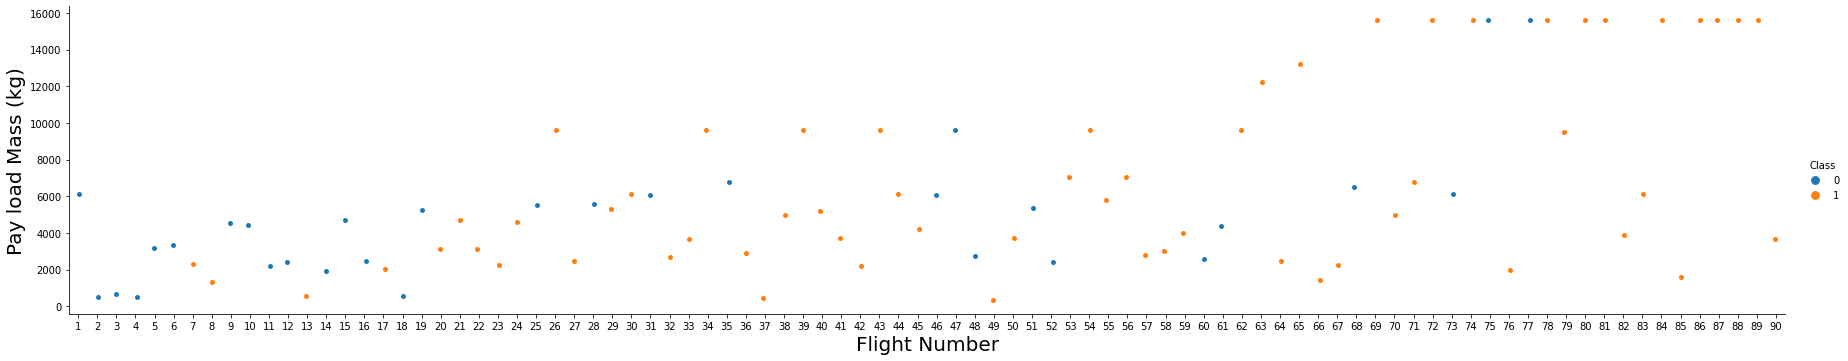

In [37]:
#Payload Mass vs Flight Number
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class",data=data_falcon9,aspect=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()


#When the payload is at maximum kg, the probability of success is high

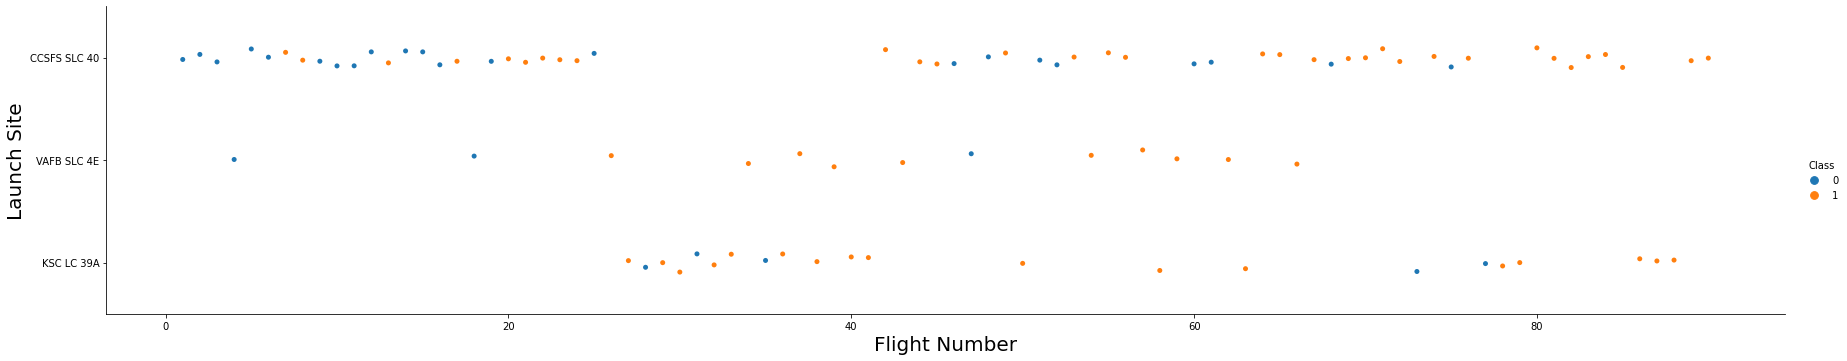

In [39]:
#Flight Number and Launch Site
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()


#VAFB SLC 4E and KSC LC 39A have better success rates as compared to CCFS SLC 40

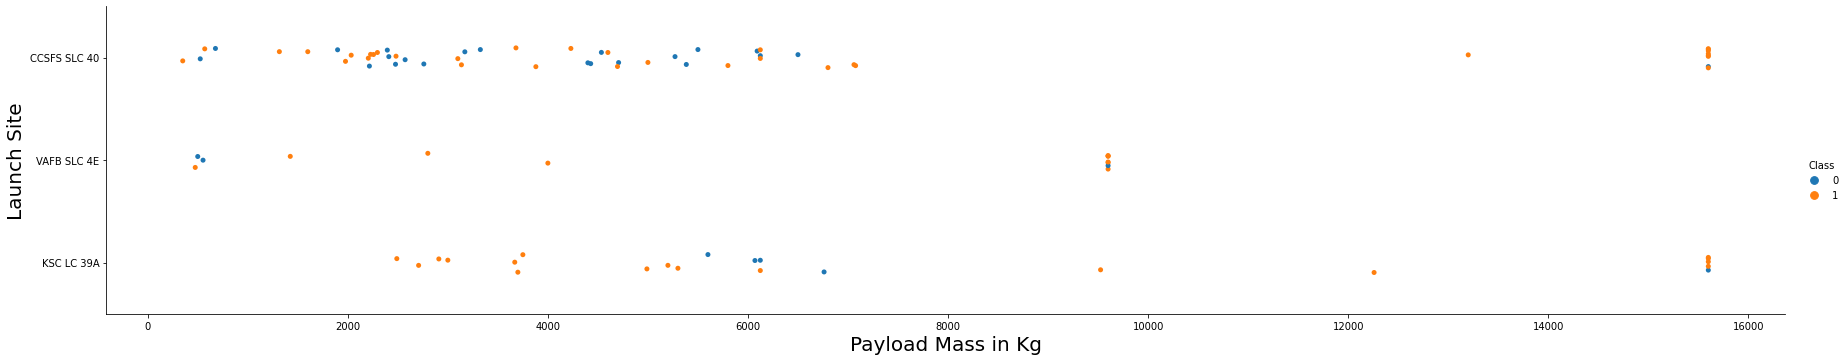

In [43]:
#Payload and Launch Site
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9,aspect= 5)
plt.xlabel("Payload Mass in Kg",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()



#For VAFB no rocket has been launched past 10,000. The rocket launch is more likely to fail if the payload is below 8000

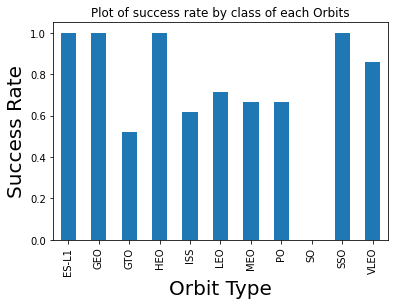

In [45]:
### TASK  3: Visualize the relationship between success rate of each orbit type

data_falcon9.groupby("Orbit").mean()['Class'].plot(kind='bar')
plt.title('Plot of success rate by class of each Orbits', fontdict={'size':12})
plt.xlabel("Orbit Type",fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.show()

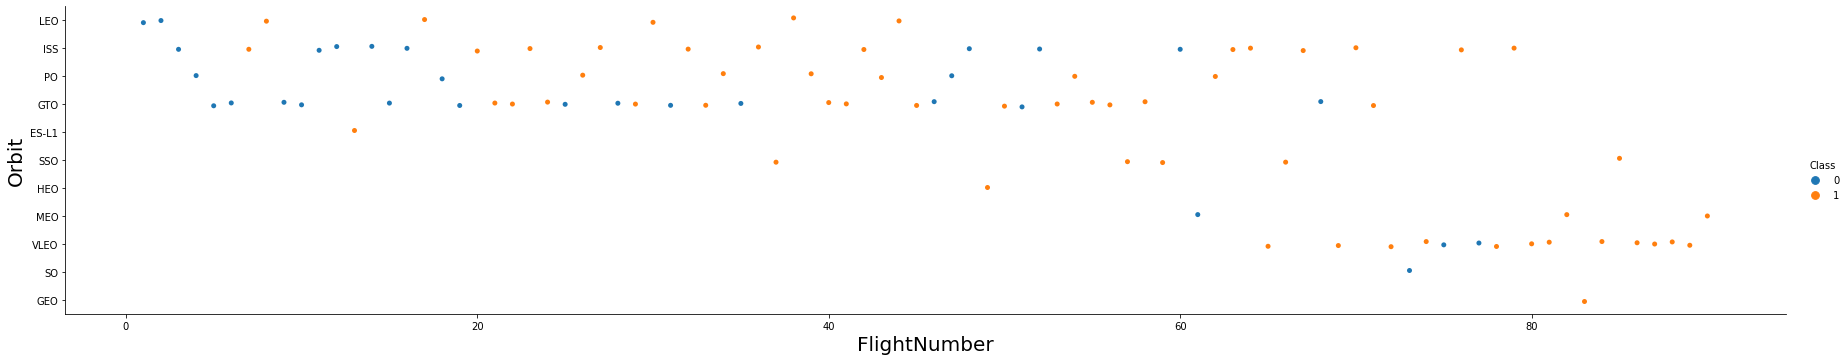

In [47]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

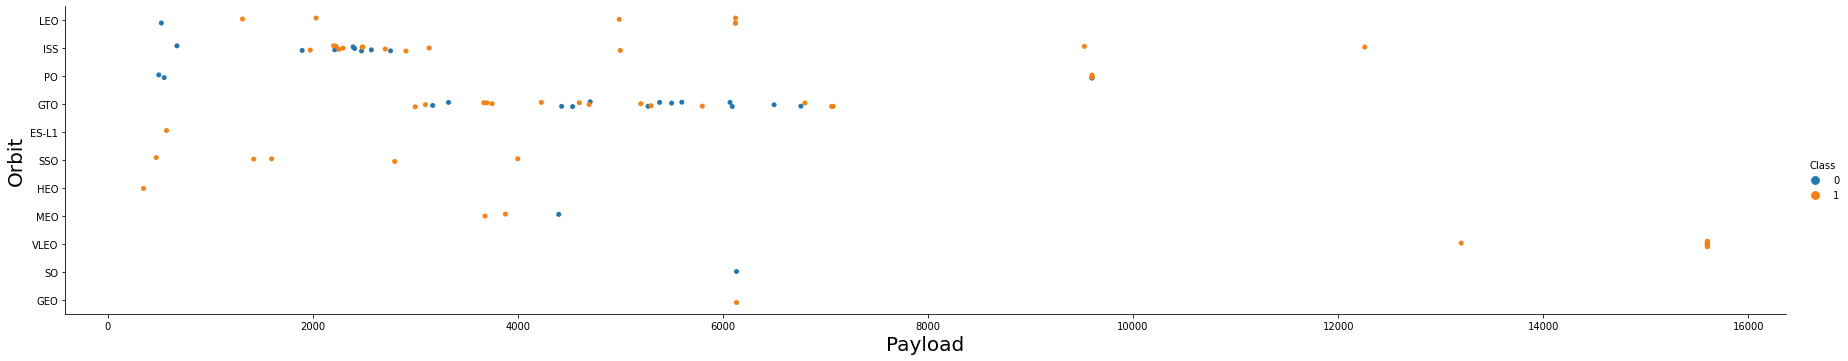

In [49]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Payload",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

**FEATURE ENGINEERING**

In [53]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [54]:
# HINT: Use get_dummies() function on the categorical columns
features_one_hot = pd.get_dummies(features, columns = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
#Convert all to float
features_one_hot = features_one_hot.astype(float)


**SPACE Y DASHBOARD**

In [60]:
!pip install wget
import wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=3dd2aaca4212d7c386cf122c85a0b1e5acb74c845cd62695a19e953fc8dc2e3e
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\ba\78\fb\e0c24a9e73d7483b073d15b7e05f43f3fc2ac75eff6899c7aa
Successfully built wget


In [61]:
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

In [62]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [70]:

%pip install folium
import folium

# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

Note: you may need to restart the kernel to use updated packages.


In [71]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [72]:
# Initialize the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=4)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for index, row in launch_sites_df.iterrows():
    coordinate = [row['Lat'], row['Long']]
    folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(row['Launch Site'])).add_to(site_map)
    folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['Launch Site'], )).add_to(site_map)
site_map


**Task 2: Mark the success/failed launches for each site on the map**

In [73]:
marker_cluster = MarkerCluster()

# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [74]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, row in spacex_df.iterrows():
    # create and add a Marker cluster to the site map
    coordinate = [row['Lat'], row['Long']]
    folium.map.Marker(coordinate, icon=folium.Icon(color='white',icon_color=row['marker_color'])).add_to(marker_cluster)
site_map

**TASK 3: Calculate the distances between a launch site to its proximities**

In [75]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [76]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [77]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
launch_site_lat = 28.563197
launch_site_lon = -80.576820
coastline_lat = 28.56334
coastline_lon = -80.56799
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
print(distance_coastline,' km')

0.8627671182499878  km


In [78]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for example
# distance_marker = folium.Marker(
#    coordinate,
#    icon=DivIcon(
#        icon_size=(20,20),
#        icon_anchor=(0,0),
#        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
#        )
#    )
distance_marker = folium.Marker(
   [coastline_lat, coastline_lon],
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )
site_map.add_child(distance_marker)

In [79]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
# lines=folium.PolyLine(locations=coordinates, weight=1)
coordinates = [[launch_site_lat,launch_site_lon],[coastline_lat,coastline_lon]]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

In [80]:
# Create a marker with distance to a closest city, railway, highway relative to CCAFS SLC-40
# Draw a line between the marker to the launch site
closest_highway = 28.56335, -80.57085
closest_railroad = 28.57206, -80.58525
closest_city = 28.10473, -80.64531

In [81]:
distance_highway = calculate_distance(launch_site_lat, launch_site_lon, closest_highway[0], closest_highway[1])
print('distance_highway =',distance_highway, ' km')
distance_railroad = calculate_distance(launch_site_lat, launch_site_lon, closest_railroad[0], closest_railroad[1])
print('distance_railroad =',distance_railroad, ' km')
distance_city = calculate_distance(launch_site_lat, launch_site_lon, closest_city[0], closest_city[1])
print('distance_city =',distance_city, ' km')

distance_highway = 0.5834695366934144  km
distance_railroad = 1.2845344718142522  km
distance_city = 51.43416999517233  km


In [82]:
# closest highway marker
distance_marker = folium.Marker(
   closest_highway,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_highway),
       )
   )
site_map.add_child(distance_marker)
# closest highway line
coordinates = [[launch_site_lat,launch_site_lon],closest_highway]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

# closest railroad marker
distance_marker = folium.Marker(
   closest_railroad,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_railroad),
       )
   )
site_map.add_child(distance_marker)
# closest railroad line
coordinates = [[launch_site_lat,launch_site_lon],closest_railroad]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

# closest city marker
distance_marker = folium.Marker(
   closest_city,
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_city),
       )
   )
site_map.add_child(distance_marker)
# closest city line
coordinates = [[launch_site_lat,launch_site_lon],closest_city]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

**MACHINE LEARNING PART**

In [83]:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
np.random.seed(0)

In [84]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

In [88]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.

In [90]:
Y = data_falcon9['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [91]:
# students get this 
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01,
        -1.57589457e+00, -9.73440458e-01, -1.05999788e-01,
        -1.05999788e-01, -6.54653671e-01, -1.05999788e-01,
        -5.51677284e-01,  3.44342023e+00, -1.85695338e-01,
        -3.33333333e-01, -1.05999788e-01, -2.42535625e-01,
        -4.29197538e-01,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01, -4.10890702e-01, -1.50755672e-01,
        -7.97724035e-01, -1.50755672e-01, -3.92232270e-01,
         9.43398113e+00, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-01,
        -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
        -1.05999788e-01, -1.50755672e-01, -1.05999788e-0

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (72, 83) (72,)
Test set: (18, 83) (18,)


In [93]:
Y_test.shape


(18,)

Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [94]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

lr=LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=10)
logreg_cv = grid_search.fit(X_train, Y_train)

In [95]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()

In [96]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


Calculate the accuracy on the test data using the method score:

In [97]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

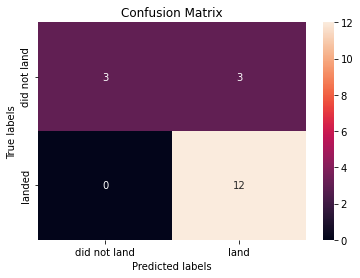

In [98]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Create a support vector machine object then create a GridSearchCV object svm_cv with cv - 10. Fit the object to find the best parameters from the dictionary parameters.

In [99]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()


In [100]:
grid_search = GridSearchCV(svm, parameters, cv=10)
svm_cv = grid_search.fit(X_train, Y_train)

In [101]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [102]:
#Calculate the accuracy on the test data using the method score:
svm_cv.score(X_test, Y_test)


0.8333333333333334

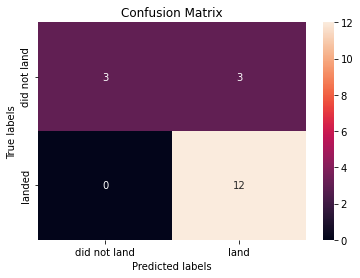

In [103]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Create a decision tree classifier object then create a GridSearchCV object tree_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [104]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [105]:
grid_search = GridSearchCV(tree, parameters, cv=10)
tree_cv = grid_search.fit(X_train, Y_train)

In [106]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.8767857142857143


In [107]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

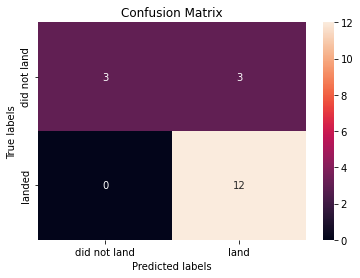

In [108]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Create a k nearest neighbors object then create a GridSearchCV object knn_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [109]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [110]:
grid_search = GridSearchCV(KNN, parameters, cv=10)
knn_cv = grid_search.fit(X_train, Y_train)

In [111]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


Calculate the accuracy of tree_cv on the test data using the method score:

In [112]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

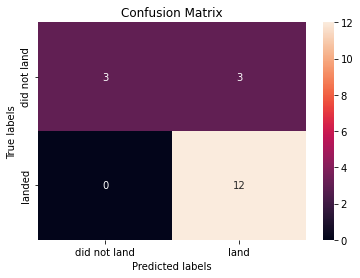

In [113]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Which model performs well??

In [114]:
models = {'KNeighbors':knn_cv.best_score_,
              'DecisionTree':tree_cv.best_score_,
              'LogisticRegression':logreg_cv.best_score_,
              'SupportVector': svm_cv.best_score_}

bestalgorithm = max(models, key=models.get)
print('Best model is', bestalgorithm,'with a score of', models[bestalgorithm])
if bestalgorithm == 'DecisionTree':
    print('Best params is :', tree_cv.best_params_)
if bestalgorithm == 'KNeighbors':
    print('Best params is :', knn_cv.best_params_)
if bestalgorithm == 'LogisticRegression':
    print('Best params is :', logreg_cv.best_params_)
if bestalgorithm == 'SupportVector':
    print('Best params is :', svm_cv.best_params_)

Best model is DecisionTree with a score of 0.8767857142857143
Best params is : {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
